In [3]:
import os
import time
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

# Turn interactive plotting off
plt.ioff()

# Location
HOME = 0
WORK = 1
QUARANTINE = 2

# Responsibility
RECKLESS = 0
RESPONSIBLE = 1

# Worker type
NORMAL = 0
REMOTE = 1

# Status
HEALTHY = 0
INFECTED = 1
INVISIBLE_TRANSMITTER = 2
TRANSMITTER = 3
CURED = 4
DEAD = 5

def calc_coords_in_circle(x, y, radius, x_size, y_size):
    """ Calculate coordinates in circle that satisfy radius & grid (must be located within) conditions
    
    :param x:      Current x coordinate in a grid
    :param y:      Current y coordinate in a grid
    :param radius: Desired radius of a circle
    :param x_size: Grid x size (of map to place people into)
    :param y_size: Grid y size (of map to place people into)
    :return:       Satisfying coordinates
    """
    
    coords = []

    # Possible y-shifts
    for i in range(-int(np.floor(radius)), int(np.floor(radius)) + 1):
        
        # Possible x-shifts
        for j in range(int(np.floor(radius)) + 1):
            
            # Coords in circle
            if np.sqrt(i ** 2 + j ** 2) <= radius:
                
                # Append valid coordinates
                if (x + j) >= 0 and (y + i) >= 0 and (x + j) < x_size and (y + i) < y_size:
                    coords.append((x + j, y + i))
                
                # Append valid mirrored coordinates
                if j > 0:
                    
                    if (x - j) >= 0 and (y + i) >= 0 and (x - j) < x_size and (y + i) < y_size:
                        coords.append((x - j, y + i))
                
            # Coords not in circle
            else:
                
                break

    return np.array(coords)


def walk_iter(cities_list, radius, neighbourhood_radius):
    """ Walk people near their home

    :param cities_list:          List of CityResidents class objects
    :param radius:               Limiting radius for one epoch walk
    :param neighbourhood_radius: Maximum distance allowed to travel for each person from his home location
    """
    
    for city in cities_list:
    
        for i, (x, y, location) in enumerate(zip(city.cur_x_arr, city.cur_y_arr, city.location_arr)):
    
            # Skip working person
            if location != HOME:
                continue

            valid_coords = False

            # Get possible moves from current (x, y) location
            coords = calc_coords_in_circle(x, y, radius, city.x_size, city.y_size)

            # Randomly choose new move that yields neighbourhood coordinates
            while not valid_coords:

                rnd_move_idx = np.random.choice(coords.shape[0], 1, replace=False)[0]
                new_x, new_y = coords[rnd_move_idx]
                if np.sqrt((new_x - city.home_x_arr[i]) ** 2 + (new_y - city.home_y_arr[i]) ** 2) <= neighbourhood_radius:
                    valid_coords = True

            city.cur_x_arr[i] = new_x
            city.cur_y_arr[i] = new_y

        
def make_disease_matrix(cities_list, city_idx, spread_radius):
    """ Make disease (exposure) matrix which indicates for each spot a number of ill people near, that can transfer a disease
    
    :param cities_list:   List of CityResidents class objects
    :param city_idx:      Index of city of interest in cities_list
    :param spread_radius: Radius of exposure of an infected person within which disease can be transfered to a healthy one
    :return:              Disease (exposure) matrix
    """

    city = cities_list[city_idx]

    # Init disease matrix
    disease_mat = np.zeros(shape=(city.y_size, city.x_size)).astype(int)

    # Get indices of residents at home with trasmittable disease
    disease_indices = np.where((city.location_arr == HOME) & ((city.status_arr == TRANSMITTER) | (city.status_arr == INVISIBLE_TRANSMITTER)))[0]

    # Calculate disease spread for each infected person
    for i in disease_indices:

        infected_coords = calc_coords_in_circle(city.cur_x_arr[i], city.cur_y_arr[i], spread_radius, city.x_size, city.y_size)

        for x, y in infected_coords:
            disease_mat[y, x] += 1

    # Process workers (residents + from other cities) with trasmittable disease
    for n in range(len(cities_list)):
    
        # Get indices of workers from other cities with trasmittable disease
        disease_indices = np.where((cities_list[n].work_city_arr == city_idx) & (cities_list[n].location_arr == WORK) & ((cities_list[n].status_arr == TRANSMITTER) | (cities_list[n].status_arr == INVISIBLE_TRANSMITTER)))[0]

        # Calculate disease spread for each infected person
        for i in disease_indices:

            infected_coords = calc_coords_in_circle(cities_list[n].work_x_arr[i], cities_list[n].work_y_arr[i], 
                                                    spread_radius, city.x_size, city.y_size)

            for x, y in infected_coords:
                disease_mat[y, x] += 1
                
    return disease_mat


def make_disease_matrices(cities_list, spread_radius):
    """ Make disease (exposure) matrices for each city
    
    :param cities_list:   List of CityResidents class objects
    :param spread_radius: Radius of exposure of an infected person within which disease can be transfered to a healthy one
    :return:              List of disease (exposure) matrices
    """
    
    disease_mat_list = []
    
    for city_idx in range(len(cities_list)):
        
        disease_mat = make_disease_matrix(cities_list, city_idx, spread_radius)
        disease_mat_list.append(disease_mat)
        
    return disease_mat_list


def calc_infection_prob(infection_exposure, infect_prob = 0.5):
    """ Calculate infection probability based on exposure and infection's base probability
    
    :param infection_exposure: Number of infected people which can transfer the disease and located near a healthy person
    :param infect_prob:        Infection's base probability
    :return:                   Probability of infection
    """
    return 1 - (1 - infect_prob) ** infection_exposure


def spread_disease(disease_mat_list, cities_list, timer_min, timer_max, transmission_time, infect_prob):
    """ Spread disease between infected and healthy people based on disease_mat_list. Updates status_arr & incubation_timer_arr in cities_list objects
    
    :param disease_mat_list:  List of maps of overlapping areas of disease exposure from current infected people
    :param cities_list:       List of CityResidents class objects
    :param timer_min:         Min steps (epochs) until infected person can transmit a disease (exception: initial group)
    :param timer_max:         Max steps (epochs) until infected person can transmit a disease (exception: initial group)
    :param transmission_time: Disease lifespan
    :param infect_prob:       Disease's base probability of transmission
    """

    for city_idx, (city, disease_mat) in enumerate(zip(cities_list, disease_mat_list)):

        # Get indices of healthy residents staying at home
        disease_indices = np.where((city.location_arr == HOME) & (city.status_arr == HEALTHY))[0]
        
        # Transmit disease between residents in city
        for i in disease_indices:
            
            infection_exposure = disease_mat[city.cur_y_arr[i], city.cur_x_arr[i]]
        
            # Calculate probability of getting ill and illness' outcome
            infection_prob = calc_infection_prob(infection_exposure, infect_prob)
            if city.responsible_people_arr[i] == RESPONSIBLE:
                infection_prob /= 10
            infection_outcome = np.random.choice([HEALTHY, INFECTED], p=[1 - infection_prob, infection_prob], replace=False)
        
            # Infect only healthy people
            assert city.status_arr[i] == HEALTHY
            if infection_outcome == INFECTED and city.incubation_timer_arr[i] == 0:
                city.status_arr[i] = infection_outcome
                # city.incubation_timer_arr[i] = np.random.choice(range(timer_min, timer_max + 1), replace=False)
                city.incubation_timer_arr[i] = timer_max

                # Instant transmitter
                if city.incubation_timer_arr[i] == 0:
                    city.status_arr[i] = INVISIBLE_TRANSMITTER
                    city.transmission_timer_arr[i] = transmission_time
                    
        # Transmit disease between working residents + other workers in city
        for n in range(len(cities_list)):

            # Get indices of healthy workers from other cities
            disease_indices = np.where((cities_list[n].work_city_arr == city_idx) & (cities_list[n].location_arr == WORK) & (cities_list[n].status_arr == HEALTHY))[0]
            
            # Transmit disease between other workers in city
            for i in disease_indices:

                infection_exposure = disease_mat[cities_list[n].work_y_arr[i], cities_list[n].work_x_arr[i]]

                # Calculate probability of getting ill and illness' outcome
                infection_prob = calc_infection_prob(infection_exposure, infect_prob)
                if cities_list[n].responsible_people_arr[i] == RESPONSIBLE:
                    infection_prob /= 10
                infection_outcome = np.random.choice([HEALTHY, INFECTED], p=[1 - infection_prob, infection_prob], replace=False)

                # Infect only healthy people
                assert cities_list[n].status_arr[i] == HEALTHY
                if infection_outcome == INFECTED and cities_list[n].incubation_timer_arr[i] == 0:
                    cities_list[n].status_arr[i] = infection_outcome
                    # cities_list[n].incubation_timer_arr[i] = np.random.choice(range(timer_min, timer_max + 1), replace=False)
                    cities_list[n].incubation_timer_arr[i] = timer_max

                    # Instant transmitter
                    if cities_list[n].incubation_timer_arr[i] == 0:
                        cities_list[n].status_arr[i] = INVISIBLE_TRANSMITTER
                        cities_list[n].transmission_timer_arr[i] = transmission_time

            
def plot_disease_exposure(cities_list, city_idx, spread_radius, epoch=None, path=None, fig=None, ax=None):
    """ Plot disease (exposure) matrix for one city
    
    :param cities_list:   List of CityResidents class objects
    :param city_idx:      Index of city of interest in cities_list
    :param spread_radius: Disease spreading radius
    :param epoch:         Current epoch in simulation
    :param path:          Absolute path to save plot to
    :param fig:           Figure object
    :param ax:            Axis to plot
    """
    
    city = cities_list[city_idx]
    
    state = 0
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 15))
        state = 1

    ax.set_xlim(0, city.x_size - 1)
    ax.set_ylim(0, city.y_size - 1)
    
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    width *= fig.dpi
    height *= fig.dpi
    
    # Plot all residents that are in that city
    home_indices = np.where(city.location_arr == HOME)[0]
    ax.scatter(city.cur_x_arr[home_indices], city.cur_y_arr[home_indices], s=1, c='grey', alpha=0.1, label='Uninfected')

    # Plot all other workers (residents + aliens) in that city
    for n in range(len(cities_list)):
        
        work_indices = np.where((cities_list[n].work_city_arr == city_idx) & (cities_list[n].location_arr == WORK))[0]
        ax.scatter(cities_list[n].work_x_arr[work_indices], cities_list[n].work_y_arr[work_indices], s=1, c='grey', alpha=0.1)
        
        
    # Plot all infected residents at home that are in that city
    ax.scatter(city.work_x_arr[(city.status_arr == INFECTED) & (city.location_arr == HOME)], 
               city.work_y_arr[(city.status_arr == INFECTED) & (city.location_arr == HOME)], s=(spread_radius * np.mean([width]) / city.x_size), c='yellow', alpha=0.5, label='Infected')
    
    # Plot all other infected workers (residents + aliens) in that city
    for n in range(len(cities_list)):
        
        work_indices = np.where((cities_list[n].work_city_arr == city_idx) & (cities_list[n].location_arr == WORK) & (cities_list[n].status_arr == INFECTED))[0]
        ax.scatter(cities_list[n].work_x_arr[work_indices], cities_list[n].work_y_arr[work_indices], s=(spread_radius * np.mean([width]) / city.x_size), c='yellow', alpha=0.5)
    
    
    # Plot all residents-transmitters at home that are in that city
    ax.scatter(city.work_x_arr[((city.status_arr == TRANSMITTER) | (city.status_arr == INVISIBLE_TRANSMITTER)) & (city.location_arr == HOME)], 
               city.work_y_arr[((city.status_arr == TRANSMITTER) | (city.status_arr == INVISIBLE_TRANSMITTER)) & (city.location_arr == HOME)], s=(spread_radius * np.mean([width]) / city.x_size), c='red', alpha=1, label='Transmitters (visible + invisible)')
    
    # Plot all other workers-transmitters (residents + aliens) in that city
    for n in range(len(cities_list)):
        
        work_indices = np.where((cities_list[n].work_city_arr == city_idx) & (cities_list[n].location_arr == WORK) & ((cities_list[n].status_arr == TRANSMITTER) | (cities_list[n].status_arr == INVISIBLE_TRANSMITTER)))[0]
        ax.scatter(cities_list[n].work_x_arr[work_indices], cities_list[n].work_y_arr[work_indices], s=(spread_radius * np.mean([width]) / city.x_size), c='red', alpha=1)
         
    ax.set_title(f'City {city_idx}={city.city_code}. Disease (exposure) matrix - transmitters (in a city) = {((city.status_arr == TRANSMITTER) | (city.status_arr == INVISIBLE_TRANSMITTER)).sum()}, infected = {(city.status_arr == INFECTED).sum()} - epoch {epoch}')
    ax.legend(loc=2)

    if state == 1:
    
        if epoch is not None and path is not None:

            # Create folder if it doesn't exist
            if not os.path.exists(path):
                os.mkdir(path)

            # Save plot
            fig.savefig(os.path.join(path, f'City_{city_idx}_{city.city_code}_disease_matrix_epoch_{epoch}.png'), dpi=300)

        plt.close(fig)
    
    
def plot_disease_exposures(cities_list, spread_radius, epoch=None, path=None):
    """ Plot disease (exposure) matrix for one city
    
    :param cities_list:   List of CityResidents class objects
    :param spread_radius: Disease spreading radius
    :param epoch:         Current epoch in simulation
    :param path:          Absolute path to save plot to
    """
    
    plot_dict = {
        0: {'x': 1, 'y': 1},
        1: {'x': 1, 'y': 0},
        2: {'x': 0, 'y': 1},
        3: {'x': 0, 'y': 2},
        4: {'x': 2, 'y': 3},
        5: {'x': 1, 'y': 3},
        6: {'x': 3, 'y': 2},
        7: {'x': 3, 'y': 1},
        8: {'x': 3, 'y': 0},
        9: {'x': 2, 'y': 0}
    }
    
    
    fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(4 * 15, 4 * 15))
    
    for city_idx in range(len(cities_list)):
        plot_disease_exposure(cities_list, city_idx, spread_radius, epoch=epoch, path=path, 
                              fig=fig, ax=ax[plot_dict[city_idx]['y'], plot_dict[city_idx]['x']])
    
    if epoch is not None and path is not None:

        # Create folder if it doesn't exist
        if not os.path.exists(path):
            os.mkdir(path)

        # Save plot
        fig.savefig(os.path.join(path, f'All_cities_disease_matrix_epoch_{epoch}.png'), dpi=300)

    plt.close(fig)
    

class CityResidents:
    
    def __init__(self, city_num, city_code, x_size, y_size, residents_num, init_transmitters_num, remote_workers, 
                 responsible_people, timer_min, timer_max, transmission_time):
        self.city_num = city_num
        self.city_code = city_code
        self.x_size = x_size
        self.y_size = y_size
        self.residents_num = residents_num
        
        self.init_home_coords()
        self.init_current_location()
        self.init_work_location()
        self.init_disease_arrays()
        self.init_infected_group(init_transmitters_num, transmission_time)
        self.init_remote_group(remote_workers)
        self.init_responsible_group(responsible_people)
        
    def init_home_coords(self):
        self.home_x_arr = np.random.randint(self.x_size, size=self.residents_num)
        self.home_y_arr = np.random.randint(self.y_size, size=self.residents_num)
        
    def init_current_location(self):
        self.cur_x_arr = self.home_x_arr.copy()
        self.cur_y_arr = self.home_y_arr.copy()
        self.location_arr = np.zeros(self.residents_num).astype(int)
        
    def init_disease_arrays(self):
        self.status_arr = np.zeros(self.residents_num).astype(int)              # Illness status
        self.incubation_timer_arr = np.zeros(self.residents_num).astype(int)    # Timer untill illness becomes observable (& transmittable)
        self.transmission_timer_arr = np.zeros(self.residents_num).astype(int)  # Timer untill illness vanishes
        
    def init_infected_group(self, init_transmitters_num, transmission_time):
        doomed_indices = np.random.choice(self.residents_num, init_transmitters_num, replace=False)
        self.status_arr[doomed_indices] = INFECTED
        self.incubation_timer_arr[doomed_indices] = np.random.choice(range(timer_min, timer_max + 1), size=doomed_indices.size, replace=True)
        
        transmitter_indices = np.where(self.incubation_timer_arr[doomed_indices] == 0)[0]
        self.status_arr[transmitter_indices] = INVISIBLE_TRANSMITTER
        self.transmission_timer_arr[transmitter_indices] = transmission_time
    
    def init_work_location(self):
        
        # Init working place as a city of residence
        self.work_city_arr = np.array(self.residents_num * [self.city_num])
        self.work_x_arr = np.random.randint(self.x_size, size=self.residents_num)
        self.work_y_arr = np.random.randint(self.y_size, size=self.residents_num)
        
    def init_remote_group(self, remote_workers):
        
        self.worker_type_arr = np.zeros(self.residents_num).astype(int)
        self.worker_type_arr[:] = NORMAL
        
        # Randomly choose remote workers
        remote_worker_indices = np.random.choice(self.residents_num, size=int(np.floor(remote_workers * self.residents_num)), replace=False)
        self.worker_type_arr[remote_worker_indices] = REMOTE
        
    def init_responsible_group(self, responsible_people):
        
        self.responsible_people_arr = np.zeros(self.residents_num).astype(int)
        self.responsible_people_arr[:] = RECKLESS
        
        # Randomly choose responsible people
        responsible_people_indices = np.random.choice(self.residents_num, size=int(np.floor(responsible_people * self.residents_num)), replace=False)
        self.responsible_people_arr[responsible_people_indices] = RESPONSIBLE
        
    def add_work_location(self, city_num, x_size, y_size, workers_num):
        
        # Randomly select 'workers_num' who will work in other city
        indices = np.random.choice(np.where(self.work_city_arr == self.city_num)[0], workers_num, replace=False)
        self.work_x_arr[indices] = np.random.randint(x_size, size=workers_num)
        self.work_y_arr[indices] = np.random.randint(y_size, size=workers_num)
        self.work_city_arr[indices] = city_num


def decrement_timers(cities_list, transmission_time, death_prob):
    """ Decrement incubation & transmission timers across cities
    
    :param cities_list:       List of CityResidents class objects
    :param transmission_time: Disease lifespan
    :param death_prob:        Probability of death after disease
    """
    
    for city in cities_list:
    
        # Make illness observable
        new_disease_observations = np.where(city.incubation_timer_arr == 1)[0]
        city.status_arr[new_disease_observations] = INVISIBLE_TRANSMITTER

        # Decrement people counter with unobservable illness
        disease_indices = np.where(city.incubation_timer_arr > 0)[0]
        city.incubation_timer_arr[disease_indices] -= 1
        
        # Finish illness - choose outcome
        disease_finish_observations = np.where((city.transmission_timer_arr == 1) & (city.location_arr != QUARANTINE))[0]
        city.status_arr[disease_finish_observations] = np.random.choice([CURED, DEAD], size=disease_finish_observations.size, p=[1 - death_prob, death_prob], replace=True)
        
        disease_finish_observations = np.where((city.transmission_timer_arr == 1) & (city.location_arr == QUARANTINE))[0]
        city.status_arr[disease_finish_observations] = np.random.choice([CURED, DEAD], size=disease_finish_observations.size, p=[1 - death_prob / 4, death_prob / 4], replace=True)
        city.location_arr[disease_finish_observations] = HOME
        
        # Decrement people counter with observable & transmittable illness
        disease_indices = np.where(city.transmission_timer_arr > 0)[0]
        city.transmission_timer_arr[disease_indices] -= 1
        
        # Make transmitters visible
        disease_indices = np.where((city.transmission_timer_arr <= int(np.floor(transmission_time / 2))) & (city.transmission_timer_arr != 0))[0]
        city.status_arr[disease_indices] = TRANSMITTER
        
        # Set timer for new transmitters
        city.transmission_timer_arr[new_disease_observations] = transmission_time
     
    
def transport_to_work(cities_list, amount='third'):
    """ Transport people to work across cities
    
    :param cities_list: List of CityResidents class objects
    """
    
    for city in cities_list:
    
        if amount == 'third':
            worker_indices = np.random.choice(np.where((city.location_arr == HOME) & (city.worker_type_arr == NORMAL))[0], int(np.floor((city.worker_type_arr == NORMAL).sum() / 3)), replace=False)
            
        elif amount == 'rest':
            worker_indices = np.where((city.location_arr == HOME) & (city.worker_type_arr == NORMAL))[0]
            
        else:
            print('[transport_to_work] amount value is undefined !')
            
        city.location_arr[worker_indices] = WORK
        
        
def transport_to_home(cities_list, amount='third'):
    """ Transport people to home across cities

    :param cities_list: List of CityResidents class objects
    """
    
    for city in cities_list:
    
        if amount == 'third':
            worker_indices = np.random.choice(np.where((city.location_arr == WORK) & (city.worker_type_arr == NORMAL))[0], int(np.floor((city.worker_type_arr == NORMAL).sum() / 3)), replace=False)
            
        elif amount == 'rest':
            worker_indices = np.where((city.location_arr == WORK) & (city.worker_type_arr == NORMAL))[0]
            
        else:
            print('[transport_to_home] amount value is undefined !')
            
        city.location_arr[worker_indices] = HOME
        
        # Reset coordinates to home
        city.cur_x_arr[worker_indices] = city.home_x_arr[worker_indices]
        city.cur_y_arr[worker_indices] = city.home_y_arr[worker_indices]
        

def screen_for_disease(cities_list, quarantine_zone_size, transmitters_test_quota, others_test_quota):
    """ Screen population for disease to move some into quarantine zone with less death rate
    
    :param cities_list:             List of CityResidents class objects
    :param quarantine_zone_size:    Quarantine zone's capacity
    :param transmitters_test_quota: Number of tests for visible transmitters
    :param others_test_quota:       Number of tests for others
    """
    
    # Calc candidates for screening in all cities
    total_candidates = 0
    quarantime_occupancy = 0
    
    for city in cities_list:
        
        candidate_mask = (city.location_arr != QUARANTINE) & (city.status_arr != DEAD) & (city.status_arr != CURED)
        total_candidates += candidate_mask.sum()
        quarantime_occupancy += (city.location_arr == QUARANTINE).sum()

    # Screen transmitters
    for city in cities_list:
        
        candidate_mask = (city.location_arr != QUARANTINE) & (city.status_arr != DEAD) & (city.status_arr != CURED)
        city_candidates = candidate_mask.sum()
        city_ratio = city_candidates / total_candidates
        city_quota = int(np.floor(city_ratio * transmitters_test_quota))  # Approximation - rounding down
        
        # Screen randomly selected transmitters
        candidate_mask = (city.location_arr != QUARANTINE) & (city.status_arr == TRANSMITTER)
        candidate_indices = np.where(candidate_mask)[0]
        if candidate_indices.size == 0:
            continue
    
        # Quarantine zone is not full yet
        if quarantime_occupancy < quarantine_zone_size:
            
            # Fill last spaces
            if quarantine_zone_size - quarantime_occupancy < city_quota:
                candidate_indices = np.random.choice(candidate_indices, min(quarantine_zone_size - quarantime_occupancy, candidate_indices.size), replace=False)
                city.location_arr[candidate_indices] = QUARANTINE
                quarantime_occupancy = quarantine_zone_size
                break  # No space left
                
            # Transfer all transmitters to quarantine zone
            else:
                candidate_indices = np.random.choice(candidate_indices, min(city_quota, candidate_indices.size), replace=False)
                city.location_arr[candidate_indices] = QUARANTINE
                quarantime_occupancy += city_quota
                
    # Screen others
    for city in cities_list:
        
        candidate_mask = (city.location_arr != QUARANTINE) & (city.status_arr != DEAD) & (city.status_arr != CURED)
        city_candidates = candidate_mask.sum()
        city_ratio = city_candidates / total_candidates
        city_quota = int(np.floor(city_ratio * others_test_quota))  # Approximation - rounding down
        
        # Screen randomly selected others
        infected_mask = (city.location_arr != QUARANTINE) & (city.status_arr == INFECTED)
        healthy_mask = (city.location_arr != QUARANTINE) & (city.status_arr == HEALTHY)
        if infected_mask.sum() == 0:
            continue

        # candidate_mask = (city.location_arr != QUARANTINE) & ((city.status_arr == INFECTED) | (city.status_arr == HEALTHY))
        # candidate_indices = np.where(candidate_mask)[0]
        
        # Simulate random selection of infected group from infected + healthy population
        if city_quota >= infected_mask.sum() + healthy_mask.sum():
            candidate_indices = np.where(infected_mask)[0]
        else:
            candidate_indices = np.where(infected_mask)[0]
            candidate_indices = np.random.choice(candidate_indices, int(np.ceil(infected_mask.sum() * (city_quota / (infected_mask.sum() + healthy_mask.sum())))), replace=False)
        if candidate_indices.size == 0:
            continue
    
        # Quarantine zone is not full yet
        if quarantime_occupancy < quarantine_zone_size:
            
            # Fill last spaces
            if quarantine_zone_size - quarantime_occupancy < city_quota:
                candidate_indices = np.random.choice(candidate_indices, min(quarantine_zone_size - quarantime_occupancy, candidate_indices.size), replace=False)
                city.location_arr[candidate_indices] = QUARANTINE
                quarantime_occupancy = quarantine_zone_size
                break  # No space left
                
            # Transfer all transmitters to quarantine zone
            else:
                candidate_indices = np.random.choice(candidate_indices, min(city_quota, candidate_indices.size), replace=False)
                city.location_arr[candidate_indices] = QUARANTINE
                quarantime_occupancy += city_quota
                

def track_stats(cities_list, healthy_tracker, infected_tracker, invisible_transmitters_tracker, transmitters_tracker, cured_tracker, dead_tracker):
    """ Track infected & transmitters
    
    :param cities_list:                     List of CityResidents class objects
    :param healthy_tracker:                 List of healthy people for epochs
    :param infected_tracker:                List of infected people for epochs
    :param invisible_transmitters_tracker:  List of invisible trasmitters for epochs
    :param transmitters_tracker:            List of visible trasmitters for epochs
    :param cured_tracker:                   List of cured people for epochs
    :param dead_tracker:                    List of dead people for epochs
    """
    
    healthy = 0
    infected = 0
    invisible_transmitters = 0
    transmitters = 0
    cured = 0
    dead = 0
    
    for city in cities_list:
        
        healthy += (city.status_arr == HEALTHY).sum()
        infected += (city.status_arr == INFECTED).sum()
        invisible_transmitters += (city.status_arr == INVISIBLE_TRANSMITTER).sum()
        transmitters += (city.status_arr == TRANSMITTER).sum()
        cured += (city.status_arr == CURED).sum()
        dead += (city.status_arr == DEAD).sum()
        
    healthy_tracker.append(healthy)
    infected_tracker.append(infected)
    invisible_transmitters_tracker.append(invisible_transmitters)
    transmitters_tracker.append(transmitters)
    cured_tracker.append(cured)
    dead_tracker.append(dead)
    
    
def simulate_transportations_with_infections(init_transmitters_num, remote_workers, responsible_people,
                                             timer_min, timer_max, transmission_time, neighbourhood_radius, 
                                             infect_prob, death_prob, radius, spread_radius, 
                                             quarantine_zone_size, transmitters_test_quota, others_test_quota,
                                             epochs, plot_disease_matrix=None):
    """ Simulate people transportation and disease spread in a square grid
    
    :param init_transmitters_num:   Initial infected people number
    :param remote_workers:          Fraction of remote workers
    :param responsible_people:      Fraction of responsible people (which have lower probability of getting ill)
    :param timer_min:               Min steps (epochs) until infected person can transmit a disease (exception: initial group)
    :param timer_max:               Max steps (epochs) until infected person can transmit a disease (exception: initial group)
    :param transmission_time:       Disease lifespan
    :param neighbourhood_radius:    Maximum distance allowed to travel for each person from his initial location
    :param infect_prob:             Base probability for disease to transmit
    :param death_prob:              Death probability after disease
    :param radius:                  Maximum radius for person to travel in single epoch
    :param spread_radius:           Disease spreading radius
    :param quarantine_zone_size:    Quarantine zone's capacity
    :param transmitters_test_quota: Number of tests for visible transmitters to have possibility to move to quarantine zone with less death rate
    :param others_test_quota:       Number of tests for others to have possibility to move to quarantine zone with less death rate
    :param epochs:                  Steps to perform during each people 1) travel and 2) spread the disease
    :param plot_disease_matrix:     Path to save plot of disease (exposure) matrix before transmitting a disease in each epoch
    :return:                        Number of ill (visible + invisible) people for each epoch, number of ill (visible) people that can transmit a disease for each epoch
    """

    ###########################
    # Init variables          #
    ###########################

    cities_list = []

    msk = CityResidents(city_num=0, city_code='msk', x_size=506, y_size=506, residents_num=126781, init_transmitters_num=init_transmitters_num, 
                        remote_workers=remote_workers, responsible_people=responsible_people, timer_min=timer_min, timer_max=timer_max, transmission_time=transmission_time)
    
    khi = CityResidents(city_num=1, city_code='khi', x_size=105, y_size=105, residents_num=2596,   init_transmitters_num=0, 
                        remote_workers=remote_workers, responsible_people=responsible_people, timer_min=timer_min, timer_max=timer_max, transmission_time=transmission_time)
    
    kra = CityResidents(city_num=2, city_code='kra', x_size=51,  y_size=51,  residents_num=1756,   init_transmitters_num=0,
                        remote_workers=remote_workers, responsible_people=responsible_people, timer_min=timer_min, timer_max=timer_max, transmission_time=transmission_time)
    
    odi = CityResidents(city_num=3, city_code='odi', x_size=44,  y_size=44,  residents_num=1355,   init_transmitters_num=0,
                        remote_workers=remote_workers, responsible_people=responsible_people, timer_min=timer_min, timer_max=timer_max, transmission_time=transmission_time)
    
    dom = CityResidents(city_num=4, city_code='dom', x_size=126, y_size=126, residents_num=1372,   init_transmitters_num=0,
                        remote_workers=remote_workers, responsible_people=responsible_people, timer_min=timer_min, timer_max=timer_max, transmission_time=transmission_time)
    
    pod = CityResidents(city_num=5, city_code='pod', x_size=64,  y_size=64,  residents_num=3081,   init_transmitters_num=0,
                        remote_workers=remote_workers, responsible_people=responsible_people, timer_min=timer_min, timer_max=timer_max, transmission_time=transmission_time)
    
    lub = CityResidents(city_num=6, city_code='lub', x_size=36,  y_size=36,  residents_num=2053,   init_transmitters_num=0,
                        remote_workers=remote_workers, responsible_people=responsible_people, timer_min=timer_min, timer_max=timer_max, transmission_time=transmission_time)
    
    sho = CityResidents(city_num=7, city_code='sho', x_size=72,  y_size=72,  residents_num=1261,   init_transmitters_num=0,
                        remote_workers=remote_workers, responsible_people=responsible_people, timer_min=timer_min, timer_max=timer_max, transmission_time=transmission_time)
    
    bal = CityResidents(city_num=8, city_code='bal', x_size=79,  y_size=79,  residents_num=5074,   init_transmitters_num=0,
                        remote_workers=remote_workers, responsible_people=responsible_people, timer_min=timer_min, timer_max=timer_max, transmission_time=transmission_time)
    
    myt = CityResidents(city_num=9, city_code='myt', x_size=59,  y_size=59,  residents_num=2355,   init_transmitters_num=0,
                        remote_workers=remote_workers, responsible_people=responsible_people, timer_min=timer_min, timer_max=timer_max, transmission_time=transmission_time)

    cities_list.append(msk)
    cities_list.append(khi)
    cities_list.append(kra)
    cities_list.append(odi)
    cities_list.append(dom)
    cities_list.append(pod)
    cities_list.append(lub)
    cities_list.append(sho)
    cities_list.append(bal)
    cities_list.append(myt)

    # Add work location for msk residents
    msk.add_work_location(city_num=khi.city_num, x_size=khi.x_size, y_size=khi.y_size, workers_num=42)
    msk.add_work_location(city_num=kra.city_num, x_size=kra.x_size, y_size=kra.y_size, workers_num=29)
    msk.add_work_location(city_num=odi.city_num, x_size=odi.x_size, y_size=odi.y_size, workers_num=22)
    msk.add_work_location(city_num=dom.city_num, x_size=dom.x_size, y_size=dom.y_size, workers_num=22)
    msk.add_work_location(city_num=pod.city_num, x_size=pod.x_size, y_size=pod.y_size, workers_num=50)
    msk.add_work_location(city_num=lub.city_num, x_size=lub.x_size, y_size=lub.y_size, workers_num=33)
    msk.add_work_location(city_num=sho.city_num, x_size=sho.x_size, y_size=sho.y_size, workers_num=20)
    msk.add_work_location(city_num=bal.city_num, x_size=bal.x_size, y_size=bal.y_size, workers_num=82)
    msk.add_work_location(city_num=myt.city_num, x_size=myt.x_size, y_size=myt.y_size, workers_num=38)

    # Add work location for residents of other cities
    khi.add_work_location(city_num=msk.city_num, x_size=msk.x_size, y_size=msk.y_size, workers_num=695)
    kra.add_work_location(city_num=msk.city_num, x_size=msk.x_size, y_size=msk.y_size, workers_num=470)
    odi.add_work_location(city_num=msk.city_num, x_size=msk.x_size, y_size=msk.y_size, workers_num=363)
    dom.add_work_location(city_num=msk.city_num, x_size=msk.x_size, y_size=msk.y_size, workers_num=367)
    pod.add_work_location(city_num=msk.city_num, x_size=msk.x_size, y_size=msk.y_size, workers_num=825)
    lub.add_work_location(city_num=msk.city_num, x_size=msk.x_size, y_size=msk.y_size, workers_num=550)
    sho.add_work_location(city_num=msk.city_num, x_size=msk.x_size, y_size=msk.y_size, workers_num=338)
    bal.add_work_location(city_num=msk.city_num, x_size=msk.x_size, y_size=msk.y_size, workers_num=1359)
    myt.add_work_location(city_num=msk.city_num, x_size=msk.x_size, y_size=msk.y_size, workers_num=631)
    
    ###########################
    # Run simulations         #
    ###########################

    timer_dict = defaultdict(list)
    
    healthy_tracker = []
    infected_tracker = []
    invisible_transmitters_tracker = []
    transmitters_tracker = []
    cured_tracker = []
    dead_tracker = []
    
    hour = 1
    
    for i in tqdm(range(1, epochs + 1)):

        if hour > 24:
            hour -= 24
        
        # Make disease visible (and transmittable) & finish disease
        if i > 1:
            start_time = time.time()
            decrement_timers(cities_list, transmission_time, death_prob)
            end_time = time.time()
            timer_dict['decrement_timers'].append(end_time - start_time)
            if DEBUG:
                print('\tdecrement_timers()\t\t{:.2f} sec.'.format(end_time - start_time))
            
        # Transport one-third of the people to work
        if (hour % 7 == 0) & (hour % 2 != 0) & (hour % 3 != 0):
            start_time = time.time()
            transport_to_work(cities_list, amount='third')
            end_time = time.time()
            timer_dict['transport_to_work'].append(end_time - start_time)
            if DEBUG:
                print('\ttransport_to_work()\t\t{:.2f} sec.'.format(end_time - start_time))
            
        # Transport one-third of the people to work
        elif (hour % 8 == 0) & (hour % 2 != 0) & (hour % 3 != 0):
            start_time = time.time()
            transport_to_work(cities_list, amount='third')
            end_time = time.time()
            timer_dict['transport_to_work'].append(end_time - start_time)
            if DEBUG:
                print('\ttransport_to_work()\t\t{:.2f} sec.'.format(end_time - start_time))
            
        # Transport rest (one-third) of the people to work
        elif (hour % 9 == 0) & (hour % 2 != 0):
            start_time = time.time()
            transport_to_work(cities_list, amount='rest')
            end_time = time.time()
            timer_dict['transport_to_work'].append(end_time - start_time)
            if DEBUG:
                print('\ttransport_to_work()\t\t{:.2f} sec.'.format(end_time - start_time))
            
        # Transport one-third of the people from work
        elif hour % 19 == 0:
            start_time = time.time()
            transport_to_home(cities_list, amount='third')
            end_time = time.time()
            timer_dict['transport_to_home'].append(end_time - start_time)
            if DEBUG:
                print('\ttransport_to_home()\t\t{:.2f} sec.'.format(end_time - start_time))
            
        # Transport one-third of the people from work
        elif hour % 20 == 0:
            start_time = time.time()
            transport_to_home(cities_list, amount='third')
            end_time = time.time()
            timer_dict['transport_to_home'].append(end_time - start_time)
            if DEBUG:
                print('\ttransport_to_home()\t\t{:.2f} sec.'.format(end_time - start_time))
            
        # Transport rest (one-third) of the people from work
        elif hour % 21 == 0:
            start_time = time.time()
            transport_to_home(cities_list, amount='rest')
            end_time = time.time()
            timer_dict['transport_to_home'].append(end_time - start_time)
            if DEBUG:
                print('\ttransport_to_home()\t\t{:.2f} sec.'.format(end_time - start_time))
            
        # Walk peaple that are near their home
        start_time = time.time()
        walk_iter(cities_list, radius, neighbourhood_radius)
        end_time = time.time()
        timer_dict['walk_iter'].append(end_time - start_time)
        if DEBUG:
            print('\twalk_iter()\t\t\t{:.2f} sec.'.format(end_time - start_time))
        
        # Observe disease maps
        start_time = time.time()
        disease_mat_list = make_disease_matrices(cities_list, spread_radius)
        end_time = time.time()
        timer_dict['make_disease_matrices'].append(end_time - start_time)
        if DEBUG:
            print('\tmake_disease_matrices()\t\t{:.2f} sec.'.format(end_time - start_time))
        
        # Plot & save disease exposure map (cities)
        if plot_disease_matrix is not None:
            
            start_time = time.time()
            
            # Plot & save all cities on single figure
            # plot_disease_exposures(cities_list, spread_radius, epoch=i, path=plot_disease_matrix)
            
            # Plot & save all cities on multiple figures
            for city_idx in range(len(cities_list)):
                plot_disease_exposure(cities_list, city_idx, spread_radius, epoch=i, path=plot_disease_matrix)
            
            # Plot & save Moscow (Hub city)
            # plot_disease_exposure(cities_list, msk.city_num, spread_radius, epoch=i, path=plot_disease_matrix)
            
            end_time = time.time()
            timer_dict['plot_disease_exposure'].append(end_time - start_time)
            if DEBUG:
                print('\tplot_disease_exposure()\t\t{:.2f} sec.'.format(end_time - start_time))
            
        # Spread disease (based on the maps above)
        start_time = time.time()
        spread_disease(disease_mat_list, cities_list, timer_min, timer_max, transmission_time, infect_prob)
        end_time = time.time()
        timer_dict['spread_disease'].append(end_time - start_time)
        if DEBUG:
            print('\tspread_disease()\t\t{:.2f} sec.'.format(end_time - start_time))
            
        # Screen population to detect disease
        start_time = time.time()
        screen_for_disease(cities_list, quarantine_zone_size, transmitters_test_quota, others_test_quota)
        end_time = time.time()
        timer_dict['screen_for_disease'].append(end_time - start_time)
        if DEBUG:
            print('\tscreen_for_disease()\t\t{:.2f} sec.'.format(end_time - start_time))
        
        # Track real stats
        start_time = time.time()
        track_stats(cities_list, healthy_tracker, infected_tracker, invisible_transmitters_tracker, transmitters_tracker, cured_tracker, dead_tracker)
        end_time = time.time()
        timer_dict['track_stats'].append(end_time - start_time)
        if DEBUG:
            print('\ttrack_stats()\t\t\t{:.2f} sec.'.format(end_time - start_time))
        
        hour += 1
        
        # Debug
        print('[epoch={}]\tinfected={}\ttransmitters(visible+invisible)={}'.format(i, infected_tracker[-1], invisible_transmitters_tracker[-1] + transmitters_tracker[-1]))
        if DEBUG:
            print('\n')
        
    return timer_dict, \
            np.array(healthy_tracker), np.array(infected_tracker), np.array(invisible_transmitters_tracker), \
            np.array(transmitters_tracker), np.array(cured_tracker), np.array(dead_tracker)

In [4]:
DEBUG = True                    # Output each main function runtime

# 1 person = 100 people
init_transmitters_num = 1       # Initial infected people number

timer_min = 0                   # Min steps (epochs) until infected person can transmit a disease (exception: initial group)
timer_max = 168                 # Max steps (epochs) until infected person can transmit a disease (exception: initial group)
transmission_time = 336         # Disease lifespan

# 1 distance point = 100 meters
neighbourhood_radius = 120      # Maximum distance allowed to travel for each person from his initial location 

# 1 epoch = 1 hour
epochs = 40                     # Steps to perform during each people 1) travel and 2) spread the disease

radius = 1.5                    # Maximum radius for person to travel in single epoch
spread_radius = 20              # Disease spreading radius
infect_prob = 1.0               # Base probability for disease to transmit
death_prob = 0.02               # Death probability after disease

# (x, z, S, j, u)
transmitters_test_quota = 0     # Number of tests for visible transmitters to have possibility to move to quarantine zone with less death rate
others_test_quota = 10          # Number of tests for others to have possibility to move to quarantine zone with less death rate
quarantine_zone_size = 10000    # Quarantine zone's capacity
remote_workers = 0.2            # Fraction of remote workers
responsible_people = 0.2        # Fraction of responsible people (which have lower probability of getting ill)

# Path to plot of disease (exposure) matrix before transmitting a disease in each epoch
plot_disease_matrix = r'C:\Users\Владислав\Downloads\Transport-networks-main\radius_{}_spread_radius_{}_infected_prob_{}'.format(str(radius).replace('.', '_'),
                                                                                                           str(spread_radius).replace('.', '_'),
                                                                                                           str(infect_prob).replace('.', '_'))

# Perform simulation (without city plots in each epoch)
timer_dict, healthy_tracker, infected_tracker, invisible_transmitters_tracker, \
transmitters_tracker, cured_tracker, dead_tracker = simulate_transportations_with_infections(init_transmitters_num, \
                                                                                                remote_workers, \
                                                                                                responsible_people, \
                                                                                                timer_min, \
                                                                                                timer_max, \
                                                                                                transmission_time, \
                                                                                                neighbourhood_radius, \
                                                                                                infect_prob, \
                                                                                                death_prob, \
                                                                                                radius, \
                                                                                                spread_radius, \
                                                                                                quarantine_zone_size, \
                                                                                                transmitters_test_quota, \
                                                                                                others_test_quota, \
                                                                                                epochs, \
                                                                                                None)

# Perform simulation (with city plots in each epoch)
# timer_dict, healthy_tracker, infected_tracker, invisible_transmitters_tracker, \
# transmitters_tracker, cured_tracker, dead_tracker = simulate_transportations_with_infections(init_transmitters_num, \
#                                                                                                 remote_workers, \
#                                                                                                 responsible_people, \
#                                                                                                 timer_min, \
#                                                                                                 timer_max, \
#                                                                                                 transmission_time, \
#                                                                                                 neighbourhood_radius, \
#                                                                                                 infect_prob, \
#                                                                                                 death_prob, \
#                                                                                                 radius, \
#                                                                                                 spread_radius, \
#                                                                                                 quarantine_zone_size, \
#                                                                                                 transmitters_test_quota, \
#                                                                                                 others_test_quota, \
#                                                                                                 epochs, \
#                                                                                                 plot_disease_matrix)

C:\Users\valik\Anaconda3\lib\site-packages\ipykernel_launcher.py:758: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


	walk_iter()			12.09 sec.
	make_disease_matrices()		0.01 sec.
	spread_disease()		7.66 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=1]	infected=1	transmitters(visible+invisible)=0


	decrement_timers()		0.00 sec.
	walk_iter()			12.07 sec.
	make_disease_matrices()		0.01 sec.
	spread_disease()		7.64 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=2]	infected=1	transmitters(visible+invisible)=0


	decrement_timers()		0.00 sec.
	walk_iter()			11.93 sec.
	make_disease_matrices()		0.01 sec.
	spread_disease()		7.64 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=3]	infected=1	transmitters(visible+invisible)=0


	decrement_timers()		0.00 sec.
	walk_iter()			11.93 sec.
	make_disease_matrices()		0.01 sec.
	spread_disease()		7.62 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=4]	infected=1	transmitters(visible+invisible)=0


	decrement_timers()		0.00 sec.
	walk_iter()			12.02 sec.
	make_disease_matr

	walk_iter()			2.42 sec.
	make_disease_matrices()		0.01 sec.
	spread_disease()		7.65 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=35]	infected=1	transmitters(visible+invisible)=0


	decrement_timers()		0.00 sec.
	walk_iter()			2.43 sec.
	make_disease_matrices()		0.01 sec.
	spread_disease()		7.62 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=36]	infected=1	transmitters(visible+invisible)=0


	decrement_timers()		0.00 sec.
	walk_iter()			2.39 sec.
	make_disease_matrices()		0.01 sec.
	spread_disease()		7.62 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=37]	infected=1	transmitters(visible+invisible)=0


	decrement_timers()		0.00 sec.
	walk_iter()			2.43 sec.
	make_disease_matrices()		0.01 sec.
	spread_disease()		7.68 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=38]	infected=1	transmitters(visible+invisible)=0


	decrement_timers()		0.00 sec.
	walk_iter()			2.42 sec.
	make_disease_matri

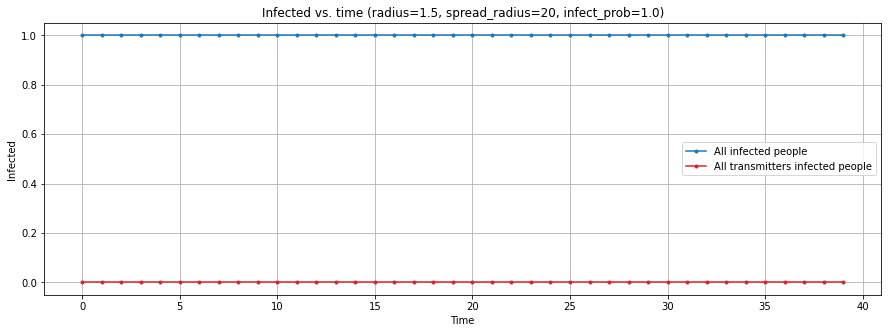

In [20]:
# Save detailed stats
df = pd.DataFrame(np.array([healthy_tracker, infected_tracker, invisible_transmitters_tracker, \
                            transmitters_tracker, cured_tracker, dead_tracker]).T, columns=['healthy', 'infected', 'invisible_transmitters', 'transmitters', 'cured', 'dead'])
df.to_csv(os.path.join(plot_disease_matrix, 'stats.csv'), sep='\t')

# Save progress plot
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(infected_tracker, '.-', c='tab:blue', label='All infected people')
ax.plot(invisible_transmitters_tracker + transmitters_tracker, '.-', c='tab:red', label='All transmitters infected people')
ax.set_ylabel('Infected')
ax.set_xlabel('Time')
ax.set_title(f'Infected vs. time (radius={radius}, spread_radius={spread_radius}, infect_prob={infect_prob})')
ax.grid()
ax.legend()

fig.savefig(os.path.join(plot_disease_matrix, 'stats_ts.png'), dpi=300);

plt.show()